In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
import matplotlib

import ncvis
import os
import numpy as np
import sys
sys.path.append("..")
from scripts.utils import get_path
from vis_utils.loaders import load_dataset
from vis_utils.plot import  plot_scatter
from vis_utils.utils import  save_dict, load_dict

import umap
import pickle

env: CUDA_VISIBLE_DEVICES=1


In [2]:
root_path = get_path("data")
fig_path = get_path("figures")

In [3]:
# parameters for all methods
a = 1.0
b = 1.0
seeds = [0, 1, 2]
n_noise = 5

parametric = False
log_embds = True
log_norms = True
log_kl = True
loss_mode = "neg_sample"
batch_size = 1024
rescale = 1.0
anneal_lr = True
momentum=0.0
lr_min_factor=0.0
clamp_low = 1e-10
on_gpu = True
optimizer = "sgd"

k = 15
dataset = "mnist"

In [4]:
plt.style.use("default")

matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = "Times New Roman"
cmap = matplotlib.cm.get_cmap("tab10")

In [5]:
# get data
x, y, sknn_graph, pca2 = load_dataset(root_path, dataset, k)
print(x.shape)
affinities = np.stack([sknn_graph.row, sknn_graph.col], axis=1)


(70000, 784)


# CNE framework

## pca init

In [6]:
n_epochs = 750
init = "pca"


In [10]:
# values of the spectrum (not in Z_bar units yet)

# transfrom Z's of t-SNE and NCVis into different unit
noise_in_estimator_tsne = 6.25 * 10**6 * n_noise / len(x) / (len(x)-1)
noise_in_estimator_tsne = float(np.format_float_scientific(noise_in_estimator_tsne,
                                                       precision=2))
noise_in_estimator_ncvis = 3.43 * 10**7 * n_noise / len(x) / (len(x)-1)
noise_in_estimator_ncvis = float(np.format_float_scientific(noise_in_estimator_ncvis,
                                                        precision=2))

nbs_noise_in_estimator =  np.array([5e-5,
                                    1e-4, 2e-4, 5e-4,
                                    1e-3, 2e-3, 5e-3,
                                    noise_in_estimator_tsne,
                                    1e-2, 2e-2, noise_in_estimator_ncvis, 5e-2,
                                    1e-1, 2e-1, 5e-1,
                                    1e-0, 2e-0, 5e-0,
                                    1e1, 2e1, 5e1,
                                    1e2, 2e2, 5e2
                                    ])


In [11]:
embedders_pca = []
for s in seeds:
    embedders_by_seed = []
    for noise_in_estimator in nbs_noise_in_estimator:
        file_name = os.path.join(root_path,
                                 dataset,
                                 f"cne_{loss_mode}_n_noise_{n_noise}_noise_in_estimator_{noise_in_estimator}_n_epochs_{n_epochs}_init_{init}_rescale_{rescale}_bs_{batch_size}"
                                 f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{s}.pkl"
                                 )

        with open(file_name, "rb") as file:
            embedder = pickle.load(file)

        embedders_by_seed.append(embedder)
    print(f"done with seed={s}")
    embedders_pca.append(embedders_by_seed)

done with seed=0
done with seed=1
done with seed=2


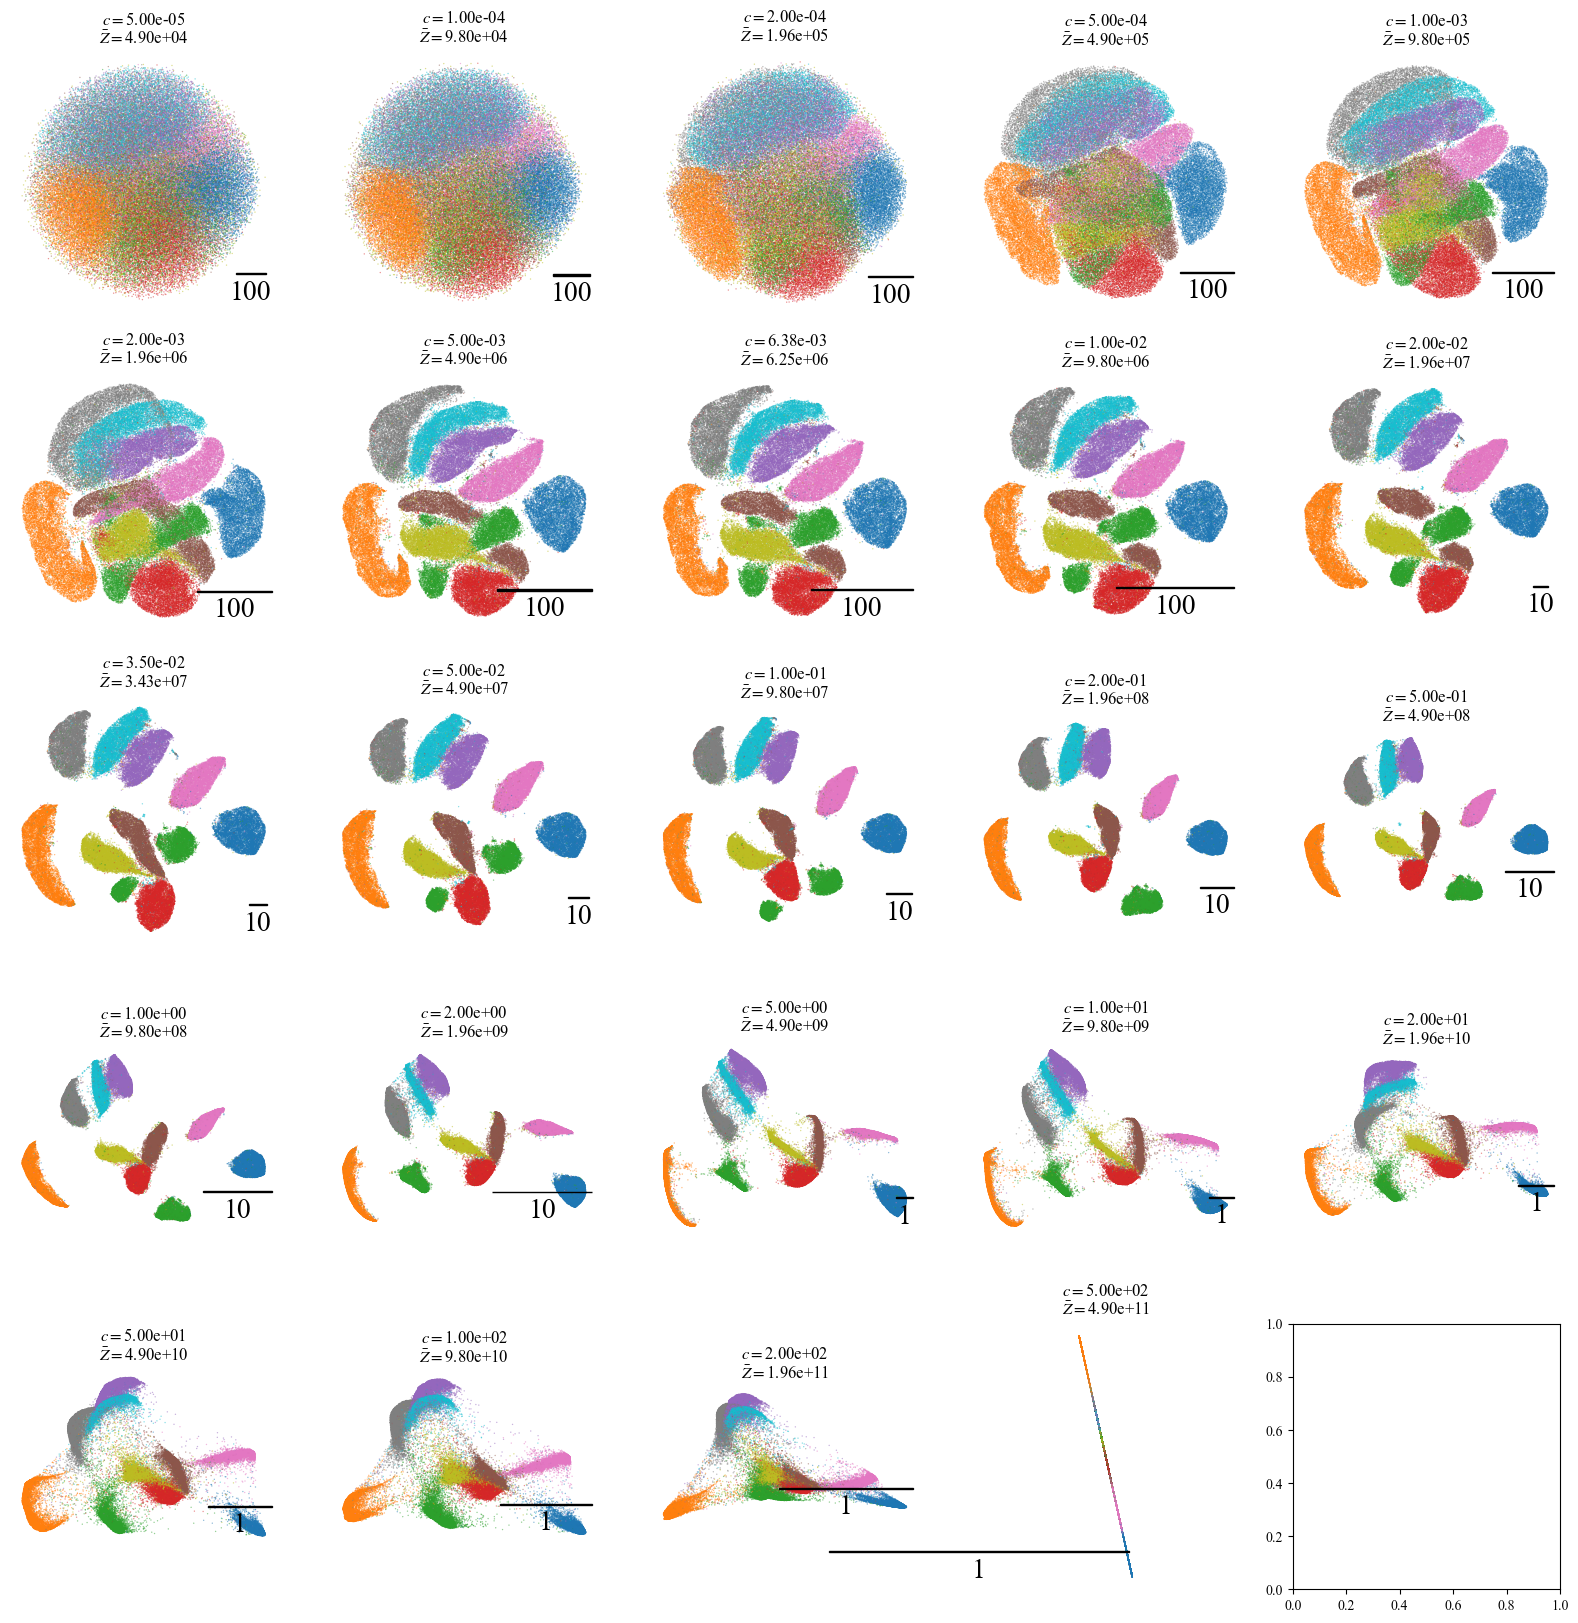

In [12]:
# show all embeddings along the spectrum
n_rows = 5
n_cols = 5
fig, ax = plt.subplots(n_rows,n_cols, figsize=(20,20))
n_exp = len(embedders_pca[0])
for i in range(n_exp):
    embd = embedders_pca[0][i].callback.embds[-1]
    cax = ax[int(i / n_cols), i % n_cols]
    cax = plot_scatter(cax,
                       embd,
                       y,
                       r"$c=${:.2e}".format(nbs_noise_in_estimator[i])
                       + "\n" +r"$\bar{Z}=$"+"{:.2e}".format(nbs_noise_in_estimator[i] / (n_noise / len(x) / (len(x)-1))))


In [13]:
indices_to_save = [0, 7, 10, 15, 20]
titles = ["cne_neg_mnist_pca_low_Z.png",
          "cne_neg_mnist_pca_Z_tsne.png",
          "cne_neg_mnist_pca_Z_ncvis.png",
          "cne_neg_mnist_pca_Z_umap.png",
          "cne_neg_mnist_pca_high_Z.png"
          ]

for i, ind in enumerate(indices_to_save):
    plt.figure(figsize=(5,5))
    plot_scatter(plt.gca(), embedders_pca[0][ind].callback.embds[-1], y)
    plt.savefig(os.path.join(fig_path,
                             titles[i]),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)
    plt.close()

In [14]:
final_norms = np.array([[embedders_pca[i][j].callback.norms[-1][0] for j in range(len(nbs_noise_in_estimator))]
                        for i in range(len(seeds))])
final_norms_mean = final_norms.mean(0)
final_norms_std = final_norms.std(0)

In [15]:
# maximal relative standard deviation
(final_norms_std / final_norms_mean ).max()

0.0063123507

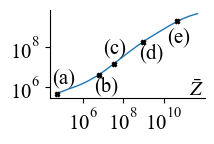

In [17]:
# panel on the partition function
Z_bars = nbs_noise_in_estimator * len(x) * (len(x) - 1) / 5

fontsize = 15
plt.figure(figsize=(2, 2))
plt.rcParams['font.size'] = fontsize
start = 0
plt.plot(Z_bars[start:], final_norms_mean[start:], label=r"$\sum_{ij} q_\theta(ij)$", linewidth=1)
plt.fill_between(Z_bars[start:],
                 final_norms_mean[start:] - final_norms_std[start:],
                 final_norms_mean[start:] + final_norms_std[start:])

plt.scatter(Z_bars[indices_to_save], final_norms_mean[indices_to_save], marker="X", s=10, c="k", zorder=5)

panel_names = ["(a)", "(b)", "(c)", "(d)", "(e)"]
for i, ind in enumerate(indices_to_save):
    if i in [1, 3]:
        plt.text(0.6*Z_bars[ind], 0.15*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})
    elif i == 4:
        plt.text(0.3*Z_bars[ind], 0.1*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})

    elif i == 0:
        plt.text(0.6*Z_bars[ind],3.5*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})
    else:
        plt.text(0.3*Z_bars[ind],3.5*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xscale("log")
plt.yscale("log")
plt.gca().set_aspect("equal")


plt.xticks([1e6, 1e8, 1e10], fontsize=fontsize)
plt.yticks([1e6, 1e8], fontsize=fontsize)

plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.gca().xaxis.set_label_coords(0.95, 0.2)
plt.savefig(os.path.join(fig_path,
                         f"cne_neg_mnist_pca_Z_spectrum.png"),
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200)

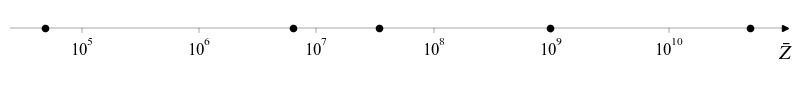

In [18]:
# spectrum axis
csfont = {'fontsize': 12}

plt.figure(figsize=(10,1))
ax = plt.gca()

plt.scatter(Z_bars[indices_to_save], np.zeros(len(indices_to_save)), s=20, c="k")
plt.xscale("log")

# dummy points, somehow necessary to get extension in y direction
plt.scatter(1e5, 0.1, c="w")
plt.scatter(1e5, -0.4, c="w")

# intersection
ax.spines['left'].set_position(('data', 1e4))
ax.spines['bottom'].set_position(('data', 0))

# visibility of axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.yaxis.set_ticks([])

#arrow tip
plt.plot(1, 0, ">k", markersize=4, transform=plt.gca().get_yaxis_transform(), clip_on=False)

# xlabel
plt.xlabel(r"$\bar{Z}$", fontsize=15)
ax.xaxis.set_label_coords(1.0, 0.55)
ax.spines["bottom"].set_linewidth(0.25)

ax.set_xticks([1e5, 1e6, 1e7, 1e8,  1e9, 1e10])
ax.xaxis.set_tick_params(width=0.25)
plt.xticks( **csfont)
plt.minorticks_off()

plt.savefig(os.path.join(fig_path,
                         f"mnist_pca_spectrum_arrow.png"),
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200)

In [20]:
times = np.array([embedders_pca[i][10].time for i in range(len(seeds))])
print(f"Mean time [min]: {times.mean() / 60}")
print(f"Std time [min]:  {times.std() / 60}")

Mean time [min]: 38.89798687034183
Std time [min]:  2.985390286973176


## early exaggeration

In [21]:
# get embedding of early exaggeration phase
n_epochs = 250

file_name = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_pca_rescale_{rescale}_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}.pkl")
with open(file_name, "rb") as file:
        embedder_init = pickle.load(file)


<AxesSubplot:>

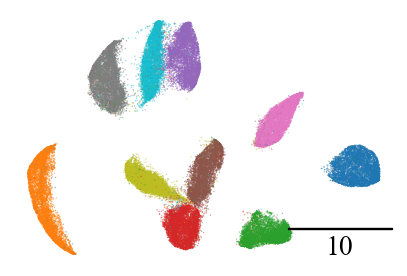

In [22]:
epoch=-1
plt.figure(figsize=(5,5))
plot_scatter(plt.gca(), embedder_init.callback.embds[epoch], y)

In [34]:
# values for the spectrum

# transform Z's of t-SNE and NCVis into correct units
noise_in_estimator_tsne = 8.13 * 10**6 * n_noise / len(x) / (len(x)-1)
noise_in_estimator_ncvis = 3.43 * 10**7 * n_noise / len(x) / (len(x)-1)

noise_in_estimator_tsne = float(np.format_float_scientific(noise_in_estimator_tsne,
                                                       precision=2))
noise_in_estimator_ncvis = float(np.format_float_scientific(noise_in_estimator_ncvis,
                                                        precision=2))


nbs_noise_in_estimator =  np.array([5e-5,
                                    1e-4, 2e-4, 5e-4,
                                    1e-3, 2e-3, 5e-3,
                                    noise_in_estimator_tsne,
                                    1e-2, 2e-2,
                                    noise_in_estimator_ncvis,
                                    5e-2,
                                    1e-1, 2e-1, 5e-1,
                                    1, 2, 5,
                                    10, 20, 50,
                                    100, 200, 500
                                    ])


In [35]:
n_epochs = 500

embedders = []
for seed in seeds:
    embedders_by_seed = []
    for noise_in_estimator in nbs_noise_in_estimator:

        file_name = os.path.join(root_path,
                                 dataset,
                                 f"cne_{loss_mode}_n_noise_{n_noise}_noise_in_estimator_{noise_in_estimator}_n_epochs_{n_epochs}_init_EE_bs_{batch_size}"
                                 f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{seed}.pkl"
                                 )

        with open(file_name, "rb") as file:
            embedder = pickle.load(file)

        embedders_by_seed.append(embedder)
    embedders.append(embedders_by_seed)
    print(f"Done with seed {seed}")

Done with seed 0
Done with seed 1
Done with seed 2


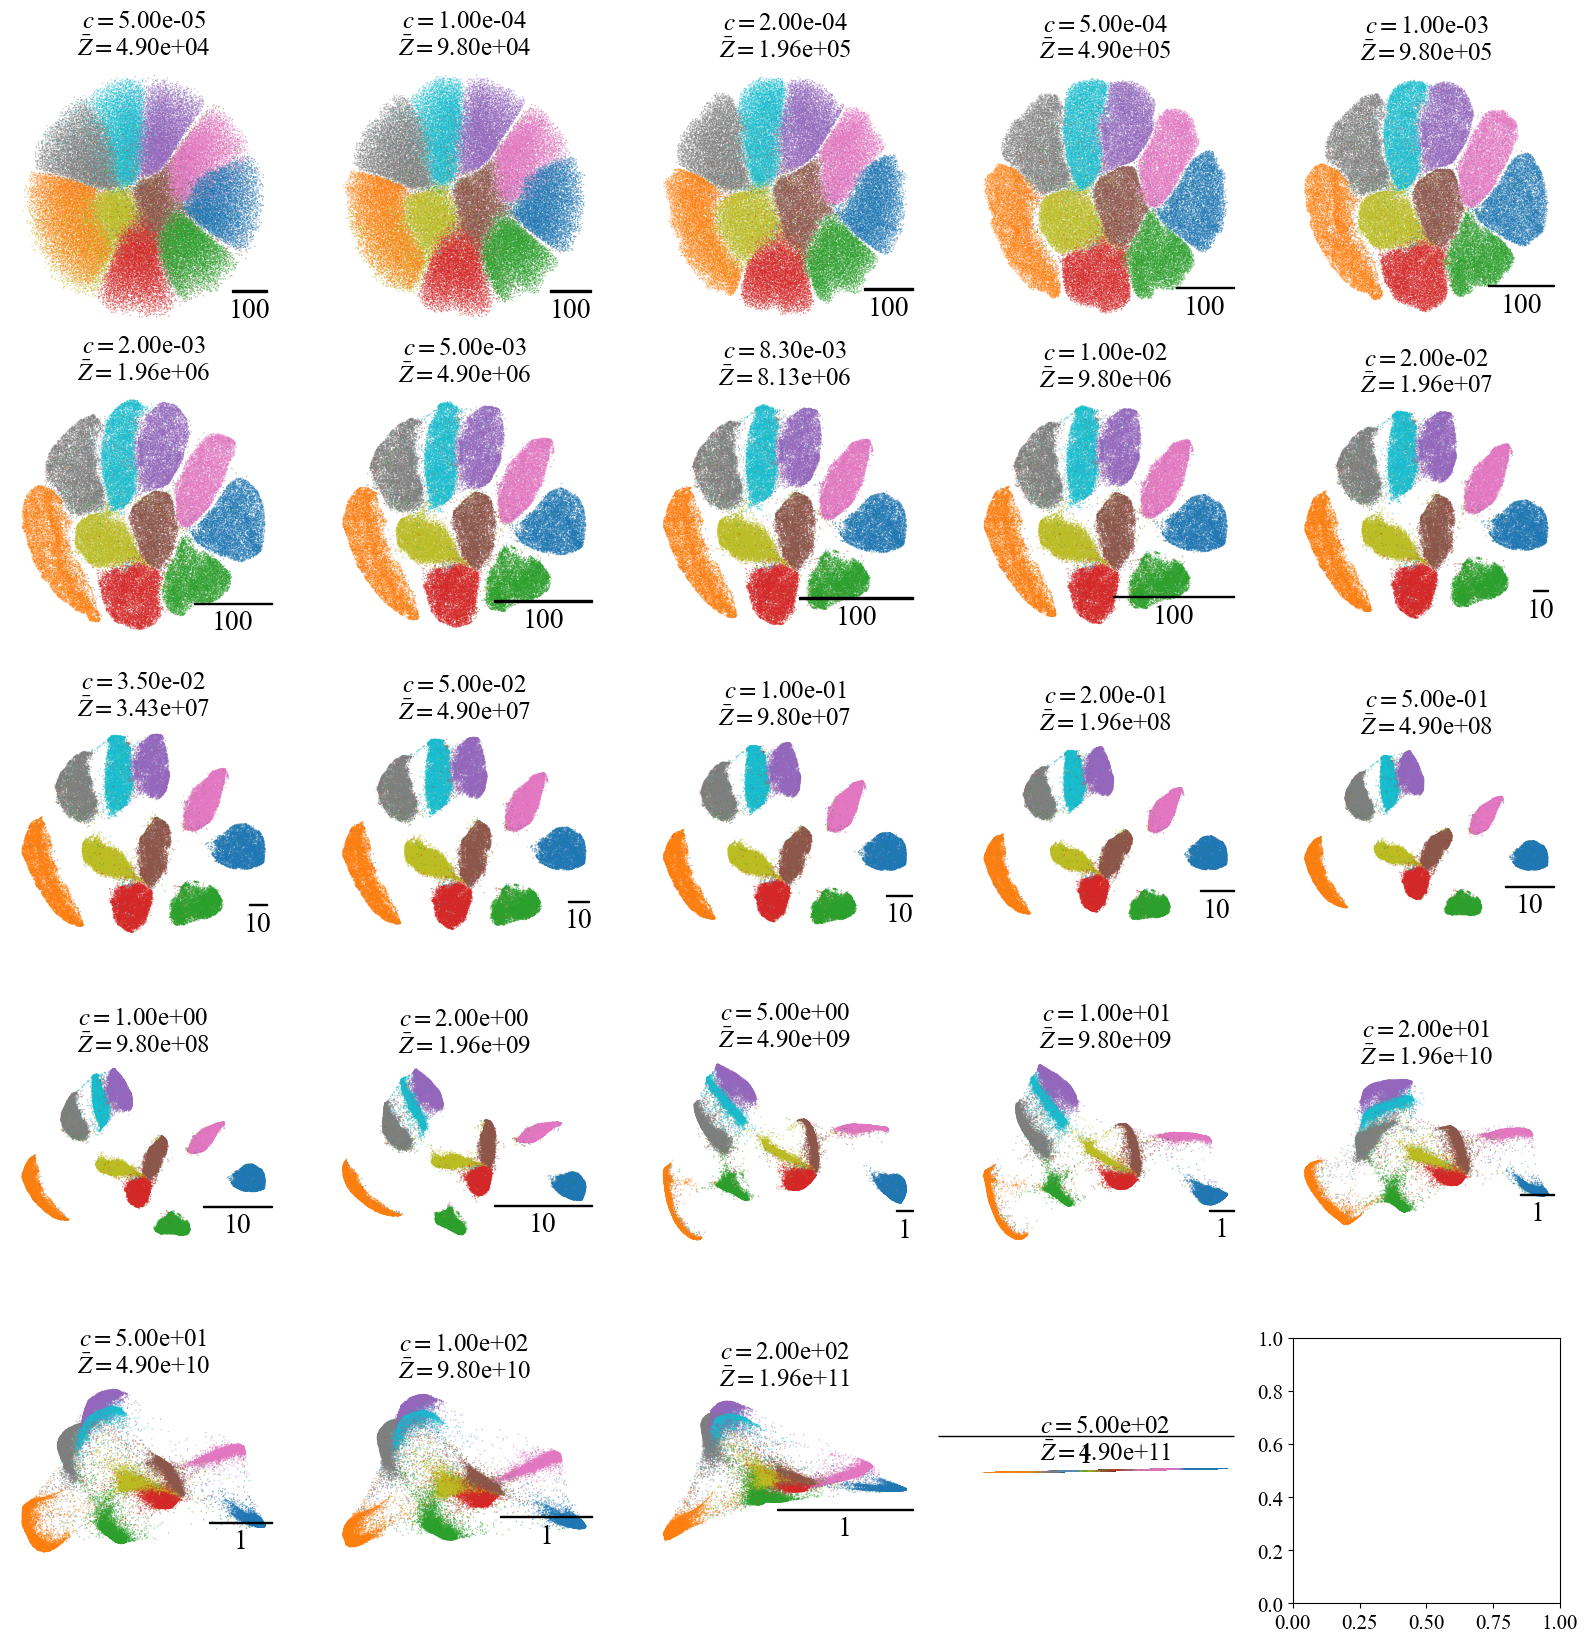

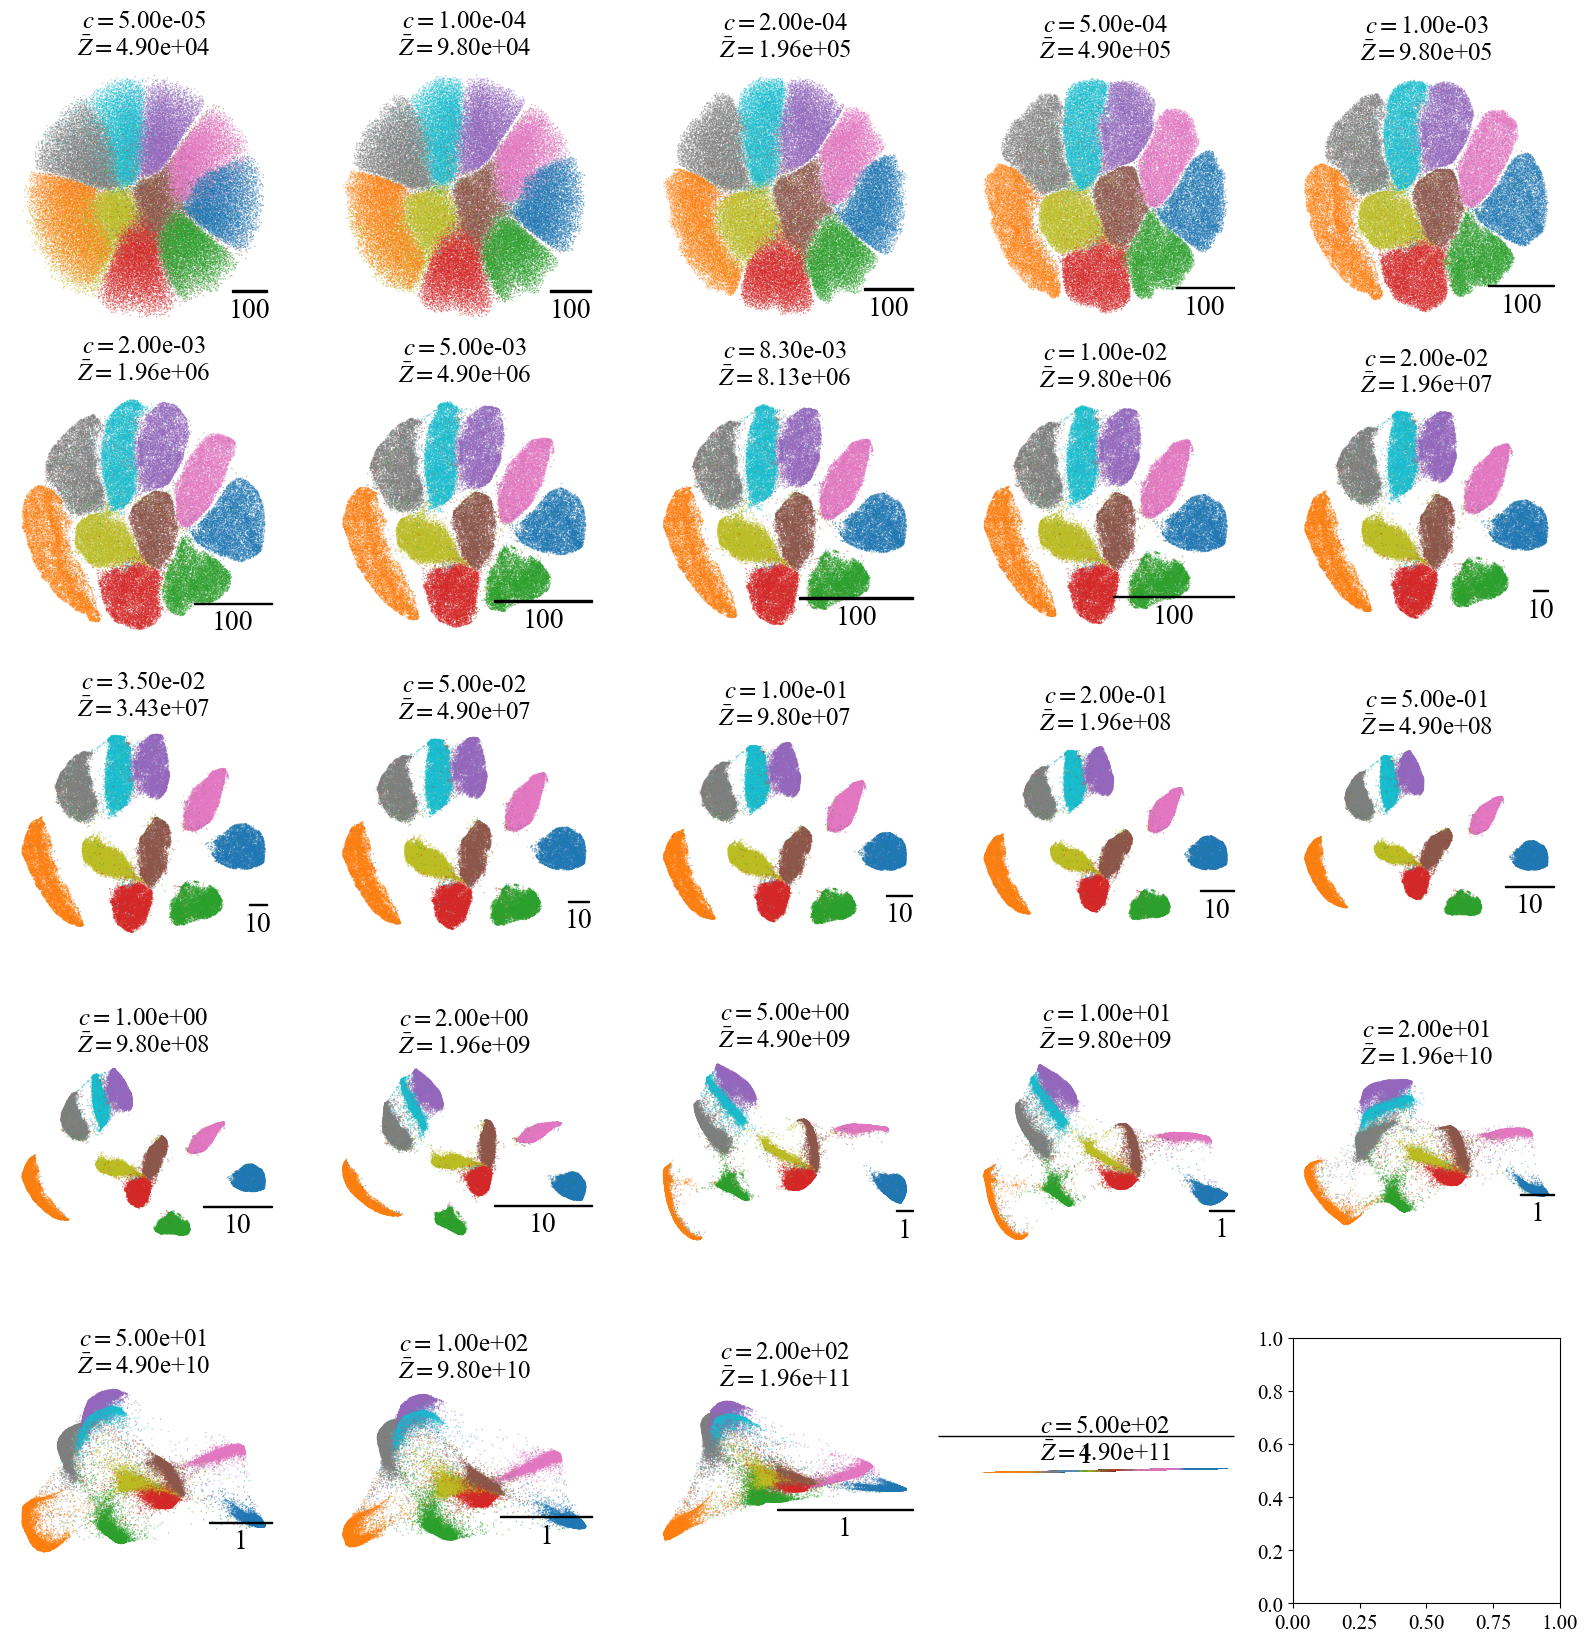

In [37]:
# show all embeddings of the spectrum
n_rows = 5
n_cols = 5
fig, ax = plt.subplots(n_rows,n_cols, figsize=(20,20))
n_exp = len(embedders[0])
for i in range(n_exp):
    embd = embedders[0][i].callback.embds[-1]
    cax = ax[int(i / n_cols), i % n_cols]

    cax = plot_scatter(cax,
                       embd,
                       y,
                       r"$c=${:.2e}".format(nbs_noise_in_estimator[i])
                       + "\n" +r"$\bar{Z}=$"+"{:.2e}".format(nbs_noise_in_estimator[i] / (n_noise / len(x) / (len(x)-1))))

In [38]:
indices_to_save = [0, 7, 10, 15, 20]
titles = ["cne_neg_mnist_EE_low_Z.png",
          "cne_neg_mnist_EE_Z_tsne.png",
          "cne_neg_mnist_EE_Z_ncvis.png",
          "cne_neg_mnist_EE_Z_umap.png",
          "cne_neg_mnist_EE_high_Z.png"
          ]

In [39]:

for i, ind in enumerate(indices_to_save):
    plt.figure(figsize=(5,5))
    plot_scatter(plt.gca(), embedders[0][ind].callback.embds[-1], y)
    plt.savefig(os.path.join(fig_path,
                             titles[i]),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)
    plt.close()

In [40]:
final_norms = np.array([[embedders[i][j].callback.norms[-1][0] for j in range(len(nbs_noise_in_estimator))]
                        for i in range(len(seeds))])
final_norms_mean = final_norms.mean(0)
final_norms_std = final_norms.std(0)
Z_bars = nbs_noise_in_estimator * len(x) * (len(x) - 1) / 5


In [41]:
# maximal relative std
(final_norms_std / final_norms_mean ).max()

0.0017559998

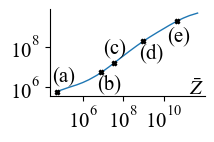

In [43]:
# panel on the partition function
fontsize = 15
plt.figure(figsize=(2, 2))
start = 0
plt.plot(Z_bars[start:], final_norms_mean[start:], label=r"$\sum_{ij} q_\theta(ij)$", linewidth=1)
plt.fill_between(Z_bars[start:],
                 final_norms_mean[start:] - final_norms_std[start:],
                 final_norms_mean[start:] + final_norms_std[start:])

plt.scatter(Z_bars[indices_to_save], final_norms_mean[indices_to_save], marker="X", s=10, c="k", zorder=5)


panel_names = ["(a)", "(b)", "(c)", "(d)", "(e)"]
for i, ind in enumerate(indices_to_save):
    if i in [1, 3]:
        plt.text(0.6*Z_bars[ind], 0.15*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})
    elif i == 4:
        plt.text(0.3*Z_bars[ind], 0.1*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})

    elif i == 0:
        plt.text(0.6*Z_bars[ind],3.5*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})
    else:
        plt.text(0.3*Z_bars[ind],3.5*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xscale("log")
plt.yscale("log")
plt.gca().set_aspect("equal")

plt.xticks([1e6, 1e8, 1e10], fontsize=fontsize)
plt.yticks([1e6, 1e8], fontsize=fontsize)

plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.gca().xaxis.set_label_coords(0.95, 0.2)
plt.savefig(os.path.join(fig_path,
                         f"cne_neg_mnist_EE_Z_spectrum.png"),
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200)

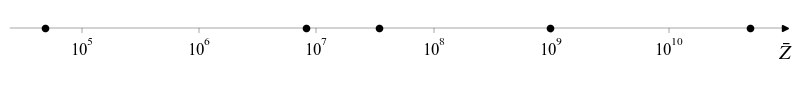

In [29]:
# spectrum axis
csfont = {'fontsize': 12}

plt.figure(figsize=(10,1))
ax = plt.gca()

plt.scatter(Z_bars[indices_to_save], np.zeros(len(indices_to_save)), s=20, c="k")
plt.xscale("log")

# dummy points, somehow necessary to get extension in y direction
plt.scatter(1e5, 0.1, c="w")
plt.scatter(1e5, -0.4, c="w")

# intersection
ax.spines['left'].set_position(('data', 1e4))
ax.spines['bottom'].set_position(('data', 0))

# visibility of axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.yaxis.set_ticks([])

#arrow tip
plt.plot(1, 0, ">k", markersize=4, transform=plt.gca().get_yaxis_transform(), clip_on=False)

# xlabel
plt.xlabel(r"$\bar{Z}$", fontsize=15)
ax.xaxis.set_label_coords(1.0, 0.55)
ax.spines["bottom"].set_linewidth(0.25)

ax.set_xticks([1e5, 1e6, 1e7, 1e8,  1e9, 1e10])
ax.xaxis.set_tick_params(width=0.25)
plt.xticks( **csfont)
plt.minorticks_off()

plt.savefig(os.path.join(fig_path,
                         f"mnist_EE_spectrum_arrow.png"),
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200)

# UMAP

In [44]:
# umap from reference implementation

In [45]:
lr = 1.0
n_epochs = 750
rescale_umap = 1.0
seed=0

if rescale_umap:
    pca_umap = pca2 / np.std(pca2[:, 0]) * rescale_umap
else:
    pca_umap = pca2

In [46]:
filename = os.path.join(root_path, "mnist", f"umap_bin_k_{k}_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}_a_{a}_b_{b}_init_pca_rescaled_{rescale_umap}.pkl")
try:
    with open(filename, "rb") as file:
        umapper = pickle.load(file)
        embd_umap = umapper.embedding_
except FileNotFoundError:
    umapper = umap.UMAP(n_neighbors=k,
                        n_epochs=n_epochs,
                        log_losses=None,
                        a=a,
                        b=b,
                        log_embeddings=True,
                        log_norm=True,
                        log_kl=True,
                        random_state=seed,
                        verbose=True,
                        init=pca_umap,
                        graph=sknn_graph,
                        learning_rate=lr)
    embd = umapper.fit_transform(x)
    with open(filename, "wb") as file:
        pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)

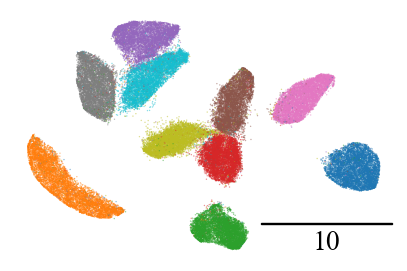

In [47]:
epoch=-1
plt.figure(figsize=(5,5))

plot_scatter(plt.gca(), umapper.aux_data["embeddings"][epoch], y)

plt.savefig(os.path.join(fig_path,
                         f"umap_mnist_bin_k_{k}_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}_a_{a}_b_{b}_init_pca_rescaled_{rescale_umap}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=200,
            transparent=False,
            facecolor="white")

# NCVIS

In [50]:
# ncvis from reference implementation

In [48]:
n_epochs = 750
rescale = 1.0
alpha = 1.0
alpha_Q = 0.001
n_noise = 5
noise_in_ratio = n_noise
seed = 0
fix_Q = False
learn_Q = True
affinities = np.stack([sknn_graph.row, sknn_graph.col], axis=1)


In [49]:
file_name = os.path.join(root_path,
                             dataset,
                             f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")

if rescale:
    pca_ncvis = pca2 / np.std(pca2[:, 0]) * rescale
else:
    pca_ncvis = pca2
try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               noise_in_ratio=noise_in_ratio,
                               learn_Q=learn_Q,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q,
                               a=a,
                               b=b)

    embd = ncvisualizer.fit_transform(x,
                                      affinities=affinities,
                                      init=pca_ncvis,
                                      log_embds=True,
                                      log_nce=False,
                                      log_nce_norm=False,
                                      log_nce_no_noise=False)
    ncvis_data = ncvisualizer.aux_data

    save_dict(ncvis_data, file_name)


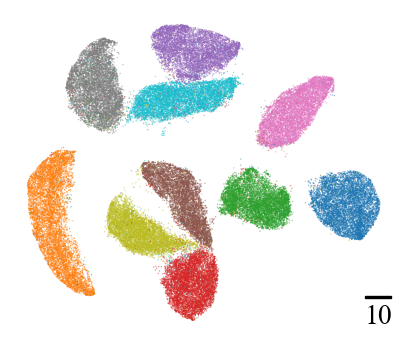

In [51]:
epoch=-1
plt.figure(figsize=(5,5))

plot_scatter(plt.gca(), ncvis_data["embds"][epoch], y)


plt.savefig(os.path.join(fig_path,
                         f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=200,
            transparent=False,
            facecolor="white")


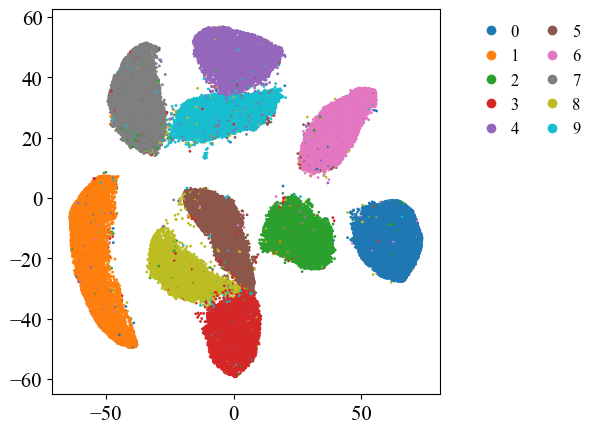

In [52]:
# get legend
plt.figure(figsize=(5, 5))
scatter = plt.scatter(*ncvis_data["embds"][-1].T,
                      s=1.0,
                      c=y,
                      cmap="tab10")

leg = plt.gca().legend(
    handles=scatter.legend_elements(num=[k for k in range(10)])[0],
    labels=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],
    bbox_to_anchor=(1.05, 1.0),
    loc="upper left",
    fontsize=12,
    ncol=2,
    handletextpad=0.2,
    columnspacing=1.0,
    frameon=False)

# get figure with legend only
fig = leg.figure
fig.canvas.draw()
bbox = leg.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(os.path.join(fig_path, "mnist_leg.png"), dpi=200, bbox_inches=bbox,
            pad_inches=0)